In [1]:
import pickle
import numpy as np
import pandas as pd
import ruptures as rpt
from pathlib import Path
from scipy.io import loadmat
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from step.data import *
from step.models import *
#from step.utils import diffusion_coefficient_tmsd

from tqdm.auto import tqdm
from fastai.vision.all import *

C:\Users\jangulo\AppData\Local\miniconda3\envs\step_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Analysis functions

In [2]:
# Defino esto aquí para que no tengas que instalar la librería
def tamsd(x, dt=1):
    "Computes the time averaged mean squared displacement of a trajectory `x`."
    return ((x[dt:] - x[:-dt])**2).sum(-1).mean()

def diffusion_coefficient_tamsd(x, t_lag=[1, 2]):
    "Estimates the diffusion coefficient fitting the `tmsd` for different `dt`."
    tamsds = [tamsd(x, dt) for dt in t_lag]
    D = np.polyfit(t_lag, tamsds, 1)[0]
    return D/2/x.shape[-1]

In [3]:
import math
 
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

def confinement_radius(x, nm_per_pxl=160):
    """Compute the confinement radius of a trajectory segment."""
    cov = np.cov(x)
    e_vals, _ = np.linalg.eigh(cov)
    return 2 * nm_per_pxl * np.sqrt(e_vals.mean())

## Load the data

We start our analysis by loading the trajectories with their predictions.

In [4]:
import mat73

In [5]:
#Processing for 1 Matlab variable
data_path = "E:/Shares/SMB_files/Jessica/video_220713_s2_c5.mat"
file = mat73.loadmat(data_path)
data_x, data_y = file["var1"]["video_file"][3:5]
all_trajectories = []
for x, y in zip(data_x, data_y):
    x = torch.tensor(x[~np.isnan(x)])
    y = torch.tensor(y[~np.isnan(y)])
    if len(x) >= 12: # at least > 0
        traj = torch.stack((x-x[0], y-y[0]))
        all_trajectories.append(traj)

ERROR:root:ERROR: MATLAB type not supported: table, (uint32)


In [42]:
##Processing for multiple Matlab variables
from tkinter import Tk, filedialog

In [185]:
# Create the Tkinter root window (it won't be shown)
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [187]:
# Create an empty list to store all trajectories
all_trajectories = []

# Loop through each selected file
for data_path in data_paths:
    file = mat73.loadmat(data_path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]

    # Create a list to store trajectories for the current file
    trajectories = []

    # Loop through x and y data and create trajectories
    for x, y in zip(data_x, data_y):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        if len(x) > 1:  # At least > 0
            traj = torch.stack((x - x[0], y - y[0]))
            trajectories.append(traj)

    # Append trajectories of the current file to the overall list
    all_trajectories.extend(trajectories)

In [204]:
# Create the Tkinter root window for the second dataset
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [205]:
# Create an empty list to store all trajectories
all_trajectories2 = []

# Loop through each selected file
for data_path in data_paths:
    file = mat73.loadmat(data_path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]

    # Create a list to store trajectories for the current file
    trajectories = []

    # Loop through x and y data and create trajectories
    for x, y in zip(data_x, data_y):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        if len(x) > 1:  # At least > 0
            traj = torch.stack((x - x[0], y - y[0]))
            trajectories.append(traj)

    # Append trajectories of the current file to the overall list
    all_trajectories2.extend(trajectories)

# Load the model

In [8]:
model_dir = "../../models"
dim = 2

In [9]:
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets

# Diffusion coefficient
# model_diff = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], pos_enc=False,
#                  n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[], norm=False, yrange=(-3.1, 3.1))
# model_diff = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], pos_enc=False,
#                  n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[], norm=False, yrange=(-4.1, 4.1))
model_diff = LogXResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], pos_enc=False,
                         n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[], norm=False, yrange=(-7.1, 2.1))
model_diff.to(default_device())

# Anomalous exponent
model_exp = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], 
                     pos_enc=False, n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[])
model_exp.to(default_device())

# Create the learners
learn_diff = Learner(dls, model_diff, loss_func=L1LossFlat(), model_dir=model_dir)
learn_exp = Learner(dls, model_exp, loss_func=L1LossFlat(), model_dir=model_dir)

In [10]:
# Model for Dif. coef. 
learn_diff.load(f'logxresattn_bm_{dim}d_1_to_4_cp_juan_72')
learn_diff.model.eval();

In [11]:
# Model for alpha
learn_exp.load(f'xresattn_exp_{dim}d_no_pe_2')
learn_exp.model.eval();

# Get predictions

In [192]:
def predict(model, x):
    return to_detach(model(x.cuda().T.unsqueeze(0).float()).squeeze())

In [40]:
preds = [predict(learn_diff.model, traj) for traj in all_trajectories]
#preds2 = [predict(learn_diff.model, traj) for traj in all_trajectories2]
pred_d = []
for i in range (len(preds)):
    pred_d.append(preds[i] + np.log10(0.1567**2/0.01))

In [298]:
# Prediction set 1
# Traj longer than 20 frames get evaluated with STEP, while trajectories shorter or equal to 20 get calculated with tMSD. 
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
pred_a, pred_d, trajectories1 = [], [], []
for traj in (all_trajectories):
    length = len(traj[0])
    if length > 20:
        pred = predict(learn_exp.model, traj)
        pred_a.append(pred + constant_value)
        pred = predict(learn_diff.model, traj)
        pred_d.append(pred)
        trajectories1.append(traj)
            

In [318]:
# Prediction set 2
# Traj longer than 20 frames get evaluated with STEP, while trajectories shorter or equal to 20 get calculated with tMSD. 
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
pred_a2, pred_d2, trajectories2 = [], [], []
for traj in (all_trajectories2):
    length = len(traj[0])
    if length > 20:
        pred = predict(learn_exp.model, traj)
        pred_a2.append(pred)
        pred = predict(learn_diff.model, traj)
        pred_d2.append(pred + constant_value)
        trajectories2.append(traj)
            

# Ensamble histograms

Text(0, 0.5, 'Frequency')

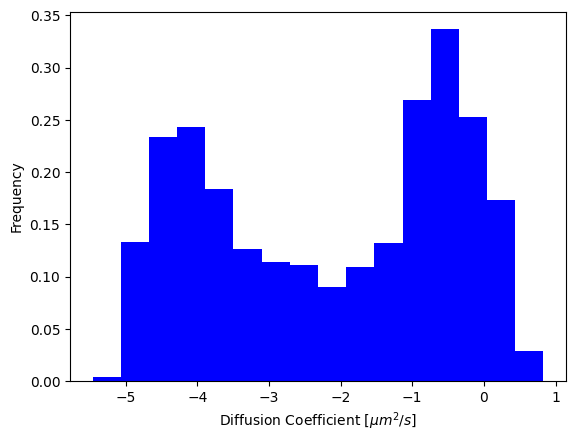

In [221]:
#Representation of one dataset
data = torch.cat(pred_d).numpy()
bin_size = int(np.ceil(np.log2(len(data))) + 1)
plt.hist(data, bins=bin_size, alpha=1, color='blue', label='WT', density=True)
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')

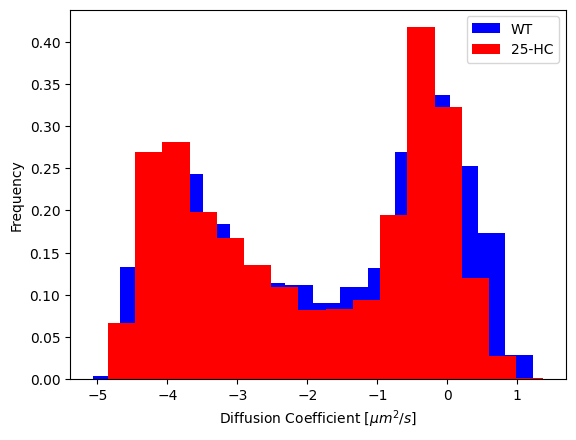

In [236]:
#Representation of both datasets
data = torch.cat(pred_d).numpy()
data2 = torch.cat(pred_d2).numpy()
bin_size1 = int(np.ceil(np.log2(len(data))) + 1)
bin_size2 = int(np.ceil(np.log2(len(data2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(data, bins=chosen_bin_size, alpha=1, color='blue', label='WT', density=True)
plt.hist(data2, bins=chosen_bin_size, alpha=1, color='red', label='25-HC', density=True)
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [305]:
preds_mean = [p.mean().numpy().item() for p in pred_d]
preds_mean2 = [p.mean().numpy().item() for p in pred_d2]

Text(0, 0.5, 'Frequency')

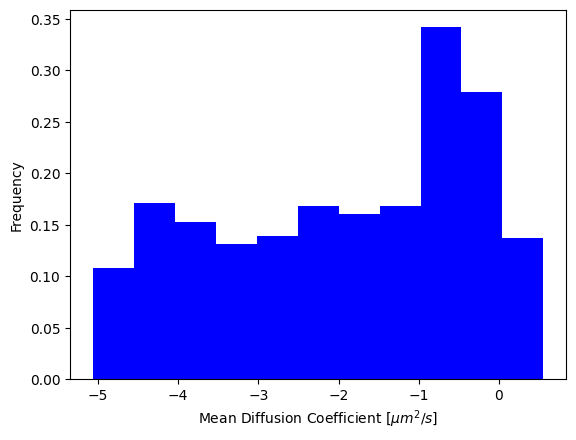

In [306]:
#Representation of one dataset
bin_size = int(np.ceil(np.log2(len(preds_mean))) + 1)
plt.hist(preds_mean, bins=bin_size, alpha=1, color='blue', label='WT', density=True);
plt.xlabel('Mean Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')

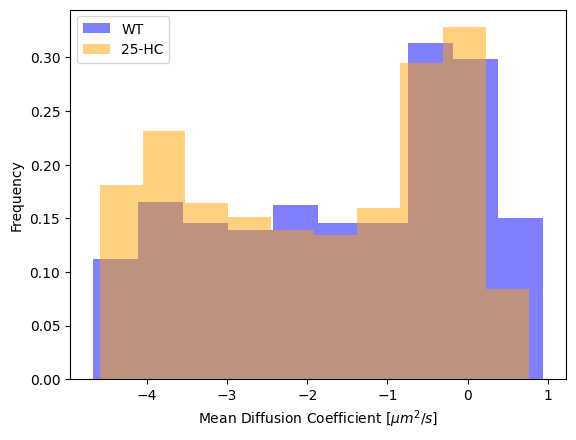

In [210]:
bin_size1 = int(np.ceil(np.log2(len(preds_mean))) + 1)
bin_size2 = int(np.ceil(np.log2(len(preds_mean2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(preds_mean, bins=chosen_bin_size, alpha=0.5, color='blue', label='WT', density=True);
plt.hist(preds_mean2, bins=chosen_bin_size, alpha=0.5, color='orange', label='25-HC', density=True);
plt.xlabel('Mean Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

# Prediction examples

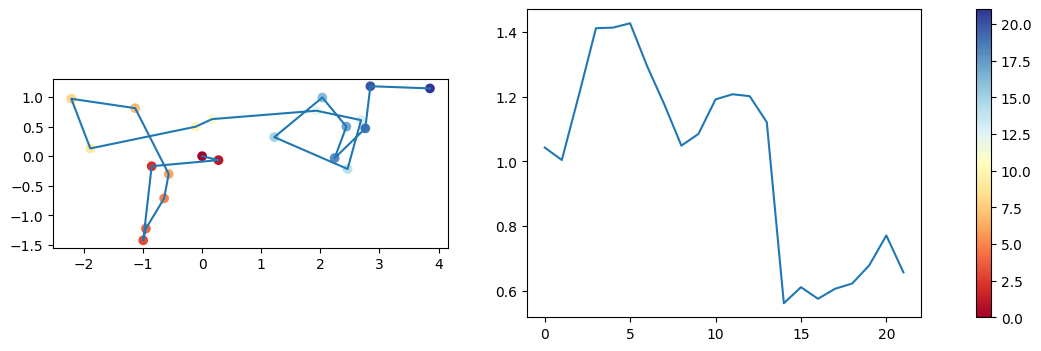

In [173]:
idx = 6
traj = trajectories1[idx]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(traj[0], traj[1])
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = axes[0].scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1, ax=axes)
axes[1].plot(pred_a[idx])
axes[0].set_aspect('equal')

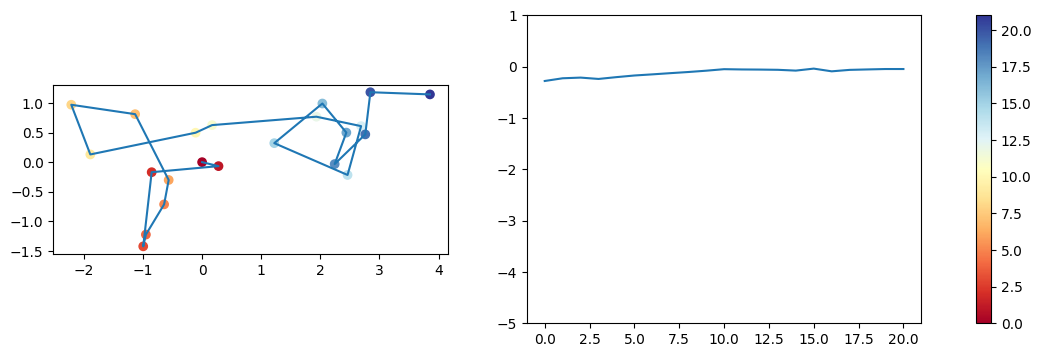

In [169]:
idx = 6
traj = trajectories1[idx]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(traj[0], traj[1])
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = axes[0].scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1, ax=axes)
axes[1].plot(pred_d[idx])
axes[1].set_ylim(-5, 1)
axes[0].set_aspect('equal')

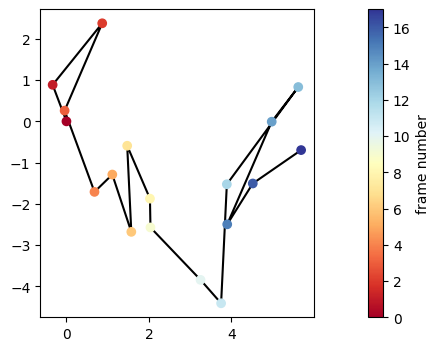

In [363]:
idx = 13
traj = trajectories1[idx]
plt.figure(figsize=(14, 4))
plt.plot(traj[0], traj[1], color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('frame number')
plt.gca().set_aspect('equal')

In [364]:
t_lag = [2, 3, 4]
D_tamsd = (diffusion_coefficient_tamsd(tensor(traj).T, t_lag))
print(D_tamsd)

0.21168321371078483


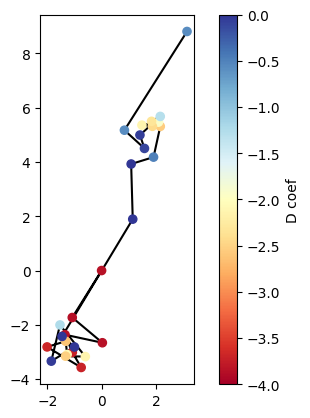

In [176]:
# Select trajectory
idx = 12
traj = trajectories1[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = pred_d[idx][-1]
preds_idx_extended = np.append(pred_d[idx], np.full(len(x) - len(pred_d[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=-4, vmax=0)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('D coef')
plt.gca().set_aspect('equal')

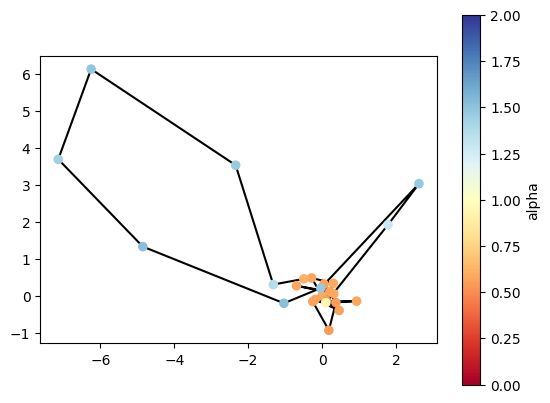

In [316]:
# Select trajectory
idx = 13
traj = trajectories1[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = pred_a[idx][-1]
preds_idx_extended = np.append(pred_a[idx], np.full(len(x) - len(pred_a[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=0, vmax=2)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('alpha')
plt.gca().set_aspect('equal')

# Trajectory segmentation

Segmentation only by diffusion coefficient: 

In [211]:
def find_segments(pred, traj, pen=1, **kwargs):
    import ruptures as rpt
    alg = rpt.KernelCPD(**kwargs).fit(pred) # Only changes in D
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, angles = [], [], [], []   
    new_d = np.ones_like(pred)
    d_tamsd = np.ones_like(pred)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        D_seg = pred[i:j].mean()
        new_d[i:j] *= D_seg
        t_lag = [1, 2, 3, 4]
        D_tamsd = np.log10(diffusion_coefficient_tamsd(tensor(segment).T, t_lag))
        d_tamsd[i:j] *= D_tamsd
        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            segments.append(segment)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)

    return new_d, d_tamsd, segments, Ds, Ds_tamsd, angles

In [213]:
seg_ds, seg_ds_tamsd, seg_angs, trajs, new_Dif, new_tamsd = [], [], [], [], [], []
for traj, pred in tqdm(zip(trajectories, pred_d)):
    pred = pred.numpy
    x, y = traj[0], traj[1]
    traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
    out = find_segments(pred, traj, min_size=4, pen=1) # previously min_size=10, pen=0.1
    new_d, d_tamsd, segments, d_seg, dtamsd_seg, angs = out
    new_Dif.append(new_d)
    new_tamsd.append(d_tamsd)
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_angs.append(angs)
    trajs.append(segments)
seg_ds = np.concatenate(seg_ds)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)

seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]

0it [00:00, ?it/s]


AttributeError: 'builtin_function_or_method' object has no attribute 'astype'

Text(0.5, 0, 'Frame number')

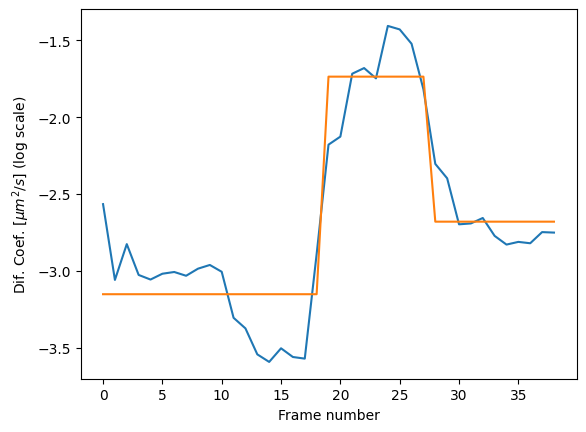

In [18]:
idx = 6
plt.plot(preds[idx])
plt.plot(new_Dif[idx])
plt.ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)')
plt.xlabel('Frame number')

Text(0, 0.5, 'Frequency')

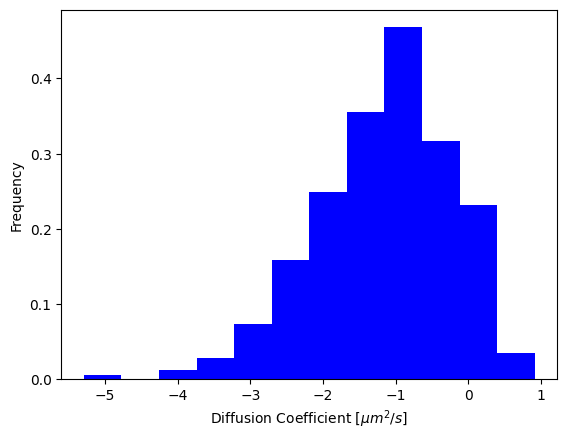

In [30]:
bin_size = int(np.ceil(np.log2(len(seg_ds_tamsd ))) + 1)
plt.hist(seg_ds_tamsd, bins=bin_size, alpha=1, color='blue', label='WT', density=True);
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')

Segmentation by both dif coef and alpha

In [319]:
def find_segments2(pred1, pred2, traj, pen=1, **kwargs):
    import ruptures as rpt
    pred = np.column_stack((pred1, pred2)) #concatenate pred_d and pred_alpha
    alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, alphas, angles = [], [], [], [], []
            
    new_d, new_a = np.ones_like(pred1), np.ones_like(pred2)
    d_tamsd = np.ones_like(pred1)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        alpha_seg, D_seg = pred2[i:j].mean(), pred1[i:j].mean()
        new_d[i:j] *= D_seg
        new_a[i:j] *= alpha_seg
        
        t_lag = [1, 2, 3, 4] if j-i >= 5 else [2, 3]
        D_tamsd = np.log10(diffusion_coefficient_tamsd(tensor(segment).T, t_lag))
        d_tamsd[i:j] *= D_tamsd
        
        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            segments.append(segment)
        alphas.append(alpha_seg)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)

    return new_d, d_tamsd, new_a, segments, Ds, Ds_tamsd, alphas, angles

In [320]:
seg_ds, seg_ds_tamsd, seg_angs, seg_alphas, trajs, new_Dif, new_alpha, new_tamsd = [], [], [], [], [], [], [], []
for traj, pred1, pred2 in tqdm(zip(trajectories2, pred_d2, pred_a2)):
    pred1 = pred1.numpy()
    pred2 = pred2.numpy()[:-1] #remove last value
    x, y = traj[0], traj[1]
    traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
    out = find_segments2(pred1, pred2, traj, min_size=4, pen=1) # previously min_size=10, pen=0.1
    new_d, d_tamsd, new_a, segments, d_seg, dtamsd_seg, alphas, angs = out
    new_Dif.append(new_d)
    new_alpha.append(new_a)
    new_tamsd.append(d_tamsd)
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_angs.append(angs)
    trajs.append(segments)
    seg_alphas.append(alphas)
seg_ds = np.concatenate(seg_ds)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_alphas = np.concatenate(seg_alphas)
seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]

0it [00:00, ?it/s]C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_39320\872114572.py:6: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_39320\2084154733.py:17: RuntimeWarning: invalid value encountered in log10
  D_tamsd = np.log10(diffusion_coefficient_tamsd(tensor(segment).T, t_lag))
444it [00:01, 319.03it/s]


Text(0.5, 0, 'Frame number')

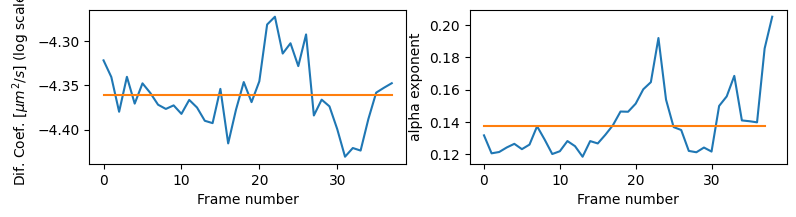

In [325]:
idx = 15
fig, axes = plt.subplots(1, 2, figsize=(9, 2))
axes[0].plot(pred_d2[idx])
axes[0].plot(new_Dif[idx])
axes[0].set_ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)')
axes[0].set_xlabel('Frame number')
axes[1].plot(pred_a2[idx])
axes[1].plot(new_alpha[idx])
axes[1].set_ylabel('alpha exponent')
axes[1].set_xlabel('Frame number')

In [264]:
seg_lens[4]

15

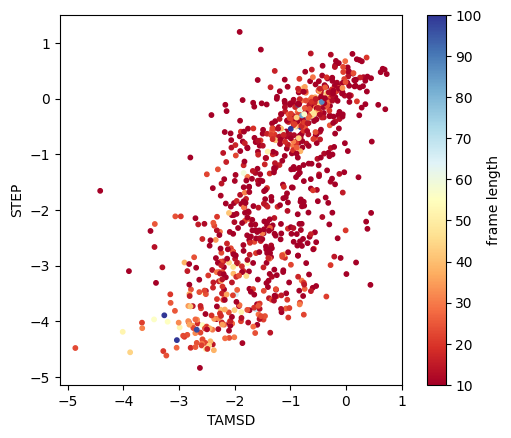

In [338]:
# Comparison D step and D TAMSD
plt.figure()
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(seg_ds_tamsd, seg_ds, c=seg_lens, s=10, cmap=cm1, zorder=2, vmin=10, vmax=100)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('frame length')
plt.xlabel('TAMSD')
plt.ylabel('STEP')
plt.gca().set_aspect('equal')

Text(0, 0.5, 'alpha')

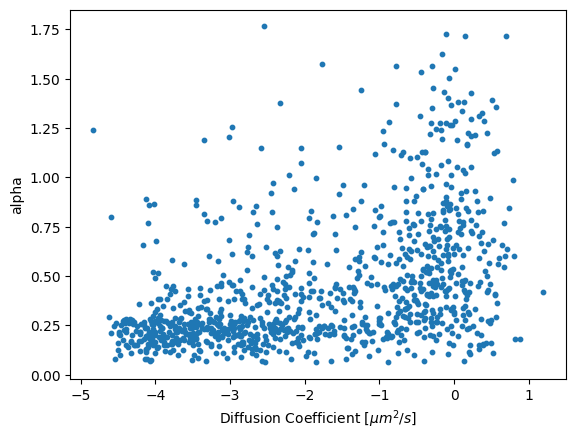

In [327]:
# Relationship diff. coef. and alpha
plt.figure()
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(seg_ds, seg_alphas, s=10)
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('alpha')

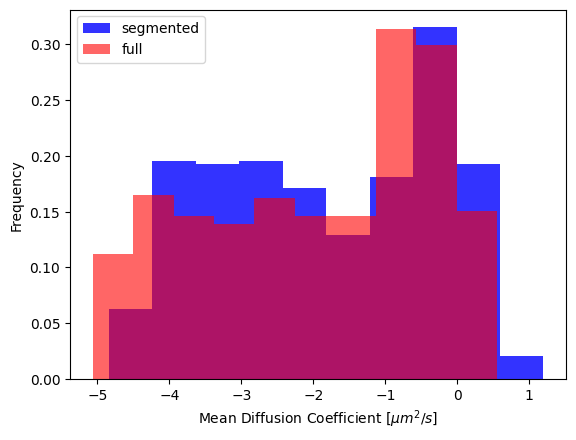

In [329]:
# Comparison before and after segmentation diff. coef. 
bin_size = int(np.ceil(np.log2(len(preds_mean2))) + 1)
plt.hist(seg_ds, bins=bin_size, alpha=0.8, color='blue', label='segmented', density=True);
plt.hist(preds_mean, bins=bin_size, alpha=0.6, color='red', label='full', density=True);
plt.xlabel('Mean Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [330]:
# Dif. coef. for short trajectories calculated with TAMSD
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
short_traj, pred_d_short = [], [],
for traj in (all_trajectories2):
    length = len(traj[0])
    if 12 < length < 20:
        t_lag = [1, 2, 3, 4]
        D_tamsd = np.log10(diffusion_coefficient_tamsd(tensor(traj).T, t_lag))
        pred_d_short.append(D_tamsd + constant_value)
        short_traj.append(traj)
all_dif2 = np.concatenate((seg_ds, pred_d_short))

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_39320\722694994.py:8: RuntimeWarning: invalid value encountered in log10
  D_tamsd = np.log10(diffusion_coefficient_tamsd(tensor(traj).T, t_lag))


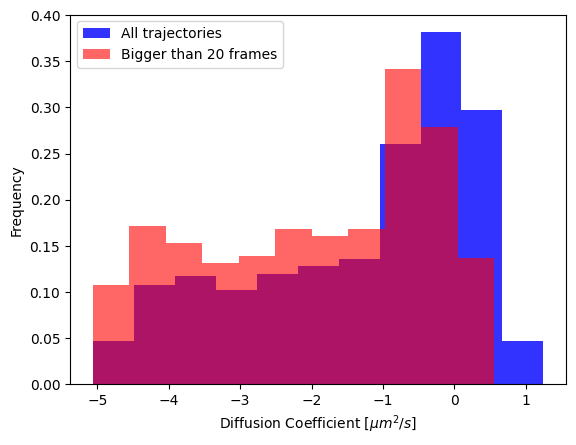

In [312]:
# Comparison before and after segmentation diff. coef. 
bin_size = int(np.ceil(np.log2(len(preds_mean))) + 1)
plt.hist(all_dif, bins=bin_size, alpha=0.8, color='blue', label='All trajectories', density=True);
plt.hist(preds_mean, bins=bin_size, alpha=0.6, color='red', label='Bigger than 20 frames', density=True);
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

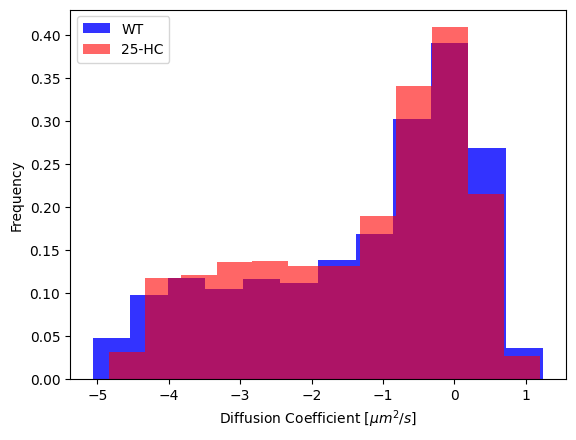

In [336]:
# Comparison 2 datasets for all Dif. coef. 
bin_size1 = int(np.ceil(np.log2(len(all_dif))) + 1)
bin_size2 = int(np.ceil(np.log2(len(all_dif2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(all_dif, bins=chosen_bin_size, alpha=0.8, color='blue', label='WT', density=True);
plt.hist(all_dif2, bins=chosen_bin_size, alpha=0.6, color='red', label='25-HC', density=True);
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()